# News Aggregation Natural Language Processing

In this notebook, we'll be extending our understanding of sequence-based modeling by extracting sentiments and signals from real-world text data.

Specifically, we'll be applying LSTM networks against corpuses of news headlines from the year 2012 to 2018 obtained from HuffPost and attempting to extract sentiment from specific reviews - both ones pulled from the dataset for testing and ones we create ourselves!

#### 🔹 General Importations

In [ ]:
# General Data Science Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Regular Expression Parsing and Word Cloud Mapping
import re, wordcloud

# Natural Language Toolkit
import nltk; nltk.download("stopwords"); nltk.download("wordnet")

# Language Token Processing and Frequency Distribution Calculator
from textblob import Word
from collections import Counter

# Generalized Machine/Deep Learning Codependencies
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow for Deep Learning
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#### 🔹 Deep Learning Functional Initializations

As good practice, let's initialize the specific tools we'll be using from `TensorFlow` to make things a little more readable moving forward.

In [ ]:
# Stopwords: Generally Recognized Noisy Terms
STOPWORDS = nltk.corpus.stopwords

# Sequential Model Architecture
Sequential = tf.keras.models.Sequential

# Connective Layers with Dropout
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

# Early Stopping Optimization
EarlyStopping = tf.keras.callbacks.EarlyStopping

# Natural Text-Based Language Processing Layers with RNN
Embedding = tf.keras.layers.Embedding
LSTM = tf.keras.layers.LSTM
SpatialDropout1D = tf.keras.layers.SpatialDropout1D

# Language Tokenization Filter
Tokenizer = tf.keras.preprocessing.text.Tokenizer

# Padding Function for Dataset Ingestion Preprocessing
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

#### 🔹 Data Loading and Preprocessing

Let's first load and take a look at what data we're working with. 

In [ ]:
CORPUS = "News_Category_Dataset_v2.csv"

dataset = pd.read_csv(CORPUS, error_bad_lines=False)
# removing entries with null values
df = dataset.dropna()
df.head(10)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26


In [ ]:
# TODO: Take out categories, make categories even ('_')

print(df['category'].nunique())
print('------------------------------')
print(df['category'].unique())
print('------------------------------')
print(df['category'].value_counts())

41
------------------------------
['CRIME' 'ENTERTAINMENT' 'IMPACT' 'POLITICS' 'WEIRD NEWS' 'WORLD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'LATINO VOICES' 'SCIENCE' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'WEDDINGS'
 'FOOD & DRINK' 'DIVORCE' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']
------------------------------
POLITICS          26913
WELLNESS          12827
ENTERTAINMENT     12192
TRAVEL             8011
STYLE & BEAUTY     7111
PARENTING          6408
HEALTHY LIVING     5072
QUEER VOICES       4669
FOOD & DRINK       4413
BUSINESS           4320
COMEDY             3709
PARENTS            3491
SPORTS             3445
HOME & LIVING      3398
BLACK VOICES       3260
IMPACT             2920
WOMEN              2840
THE WORLDPOST      2198
MEDIA              19

^^^^ TEXT ^^^^

In [ ]:
FEATURES_IMPUTED = ["headline", "category"]

processed = df[FEATURES_IMPUTED]
processed.isnull().sum()

headline    0
category    0
dtype: int64

#### 🔹 Language Processing for Data Ingestion

In [ ]:
def clean_corpus(data, stopwords, dtype="frame", feature="verified_reviews"):
  """ Function to remove special characters, digits, stop words, 
  unimportant symbols, and other unnecessary noise from our dataset. """
  if dtype == "frame":
    data[feature] = data[feature].apply(
        lambda review: " ".join(review.lower() for review in review.split())
    )
    data[feature] = data[feature].str.replace(
        r"[^A-Za-z0-9 ]", r"",
        regex=True
    )
    data[feature] = data[feature].str.replace(
        "\d+", ""
    )
    data[feature] = data[feature].apply(
        lambda token: " ".join(token for token in token.split() if token not in stopwords)
    )
    data[feature] = data[feature].apply(
        lambda token: " ".join([Word(token).lemmatize() for token in token.split()])
    )
  elif dtype == "list":
    data = [" ".join(review.lower() for review in review.split()) for review in data]
    data = [re.sub(r"[^A-Za-z0-9 ]", r"", review) for review in data]
    data = [re.sub("\d+", "", review) for review in data]
    data = [" ".join(token for token in token.split() if token not in stopwords) for token in data]
    data = [" ".join([Word(token).lemmatize() for token in token.split()]) for token in data]
  return data

^^^^ TEXT ^^^^

In [ ]:
stopwords = STOPWORDS.words("english")

processed = clean_corpus(data=processed, 
                         stopwords=stopwords,
                         dtype="frame",
                         feature="headline")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
processed.head(5)

,headline,category
0,mass shooting texas last week tv,CRIME
1,smith join diplo nicky jam world cup official ...,ENTERTAINMENT
2,hugh grant marries first time age,ENTERTAINMENT
3,jim carrey blast castrato adam schiff democrat...,ENTERTAINMENT
4,julianna margulies us donald trump poop bag pi...,ENTERTAINMENT


^^^^ TEXT ^^^^

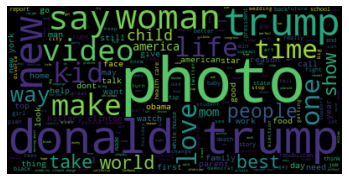

In [ ]:
common_words = str()

for headline in processed["headline"]:
  headline = str(headline)
  tokens = headline.split()
  common_words += " ".join(tokens) + " "
frequencies = wordcloud.WordCloud().generate(common_words)
plt.imshow(frequencies, interpolation="bilinear")
plt.axis("off")
plt.show()

^^^^ TEXT ^^^^

In [ ]:
label_encoder = LabelEncoder()
processed["category"] = label_encoder.fit_transform(
    processed["category"]
)

In [ ]:
processed.head(5)

,headline,category
0,mass shooting texas last week tv,6
1,smith join diplo nicky jam world cup official ...,10
2,hugh grant marries first time age,10
3,jim carrey blast castrato adam schiff democrat...,10
4,julianna margulies us donald trump poop bag pi...,10


In [ ]:
def tokenize_dataset(tokenizer, data):
  """ Function to tokenize input data for model training/testing. """
  return pad_sequences(tokenizer.texts_to_sequences(data))

In [ ]:
tokenizer = Tokenizer(num_words=500, split=" ")
tokenizer.fit_on_texts(processed["headline"].values)

X = tokenize_dataset(tokenizer, processed["headline"].values)

In [ ]:
X

array([[  0,   0,   0, ..., 194,  28, 238],
       [  0,   0,   0, ...,  16, 337, 365],
       [  0,   0,   0, ...,  27,  18, 372],
       ...,
       [  0,   0,   0, ...,   0,   0,  73],
       [  0,   0,   0, ...,  60,  11,  28],
       [  0,   0,   0, ...,   0,   0, 108]], dtype=int32)

In [ ]:
y = pd.get_dummies(processed["category"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=42)

#### 🔹 Data Ingestion and Predictive Modeling

In [ ]:
# Embedding Layer for Token-Specific Vectorization
input_embedding_layer = Embedding(500, 120, input_length=X.shape[1])

# Dropout Regularizer for Text Embedding
embedding_dropout_layer = SpatialDropout1D(0.4)

# First Recurrent LSTM Cellular Architecture
first_recurrent_layer = LSTM(176, 
                             dropout=0.2, 
                             recurrent_dropout=0.2, 
                             return_sequences=True)

# Second Recurrent LSTM Cellular Architecture
second_recurrent_layer = LSTM(176, 
                              dropout=0.2, 
                              recurrent_dropout=0.2)

# Final Dense Layer for Output Extraction
output_connective_layer = Dense(41, activation="softmax")

In [ ]:
# Sequential Model Architecture Design
model = Sequential()

# Add All Initialized Layers in Effective Sequence
model.add(input_embedding_layer)
model.add(embedding_dropout_layer)
model.add(first_recurrent_layer)
model.add(second_recurrent_layer)
model.add(output_connective_layer)

# Get Model Summary for Confirmation
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 120)           60000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 12, 120)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 176)           209088    
_________________________________________________________________
lstm_3 (LSTM)                (None, 176)               248512    
_________________________________________________________________
dense_1 (Dense)              (None, 41)                7257      
Total params: 524,857
Trainable params: 524,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile Model with Specified Loss and Optimization Functions
model.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

In [ ]:
# Define Early Stopping Callback Optimizer
callback = EarlyStopping(monitor="loss", patience=3)

# Define Batch Size and Epochs as Hyperparameters
batch_size, epochs = 32, 10

In [ ]:
# Fit Learning Model Using Training Data and Configured Hyperparameters
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback],
                    verbose=True)

Epoch 1/10
3259/3259 [==============================] - 369s 112ms/step - loss: 2.6683 - accuracy: 0.3221
Epoch 2/10
3259/3259 [==============================] - 362s 111ms/step - loss: 2.4255 - accuracy: 0.3769
Epoch 3/10
3259/3259 [==============================] - 397s 122ms/step - loss: 2.3597 - accuracy: 0.3894
Epoch 4/10
3259/3259 [==============================] - 424s 130ms/step - loss: 2.3194 - accuracy: 0.3955
Epoch 5/10
3259/3259 [==============================] - 394s 121ms/step - loss: 2.2889 - accuracy: 0.4013
Epoch 6/10
3259/3259 [==============================] - 384s 118ms/step - loss: 2.2630 - accuracy: 0.4059
Epoch 7/10
3259/3259 [==============================] - 375s 115ms/step - loss: 2.2412 - accuracy: 0.4101
Epoch 8/10
3259/3259 [==============================] - 386s 118ms/step - loss: 2.2224 - accuracy: 0.4135
Epoch 9/10
3259/3259 [==============================] - 405s 124ms/step - loss: 2.2000 - accuracy: 0.4170
Epoch 10/10
3259/3259 [=======================

In [ ]:
# Evaluate Learned Model Using Testing Data
model.evaluate(X_test, y_test)

1397/1397 [==============================] - 27s 19ms/step - loss: 2.2946 - accuracy: 0.4046


[2.2945611476898193, 0.40458664298057556]

In [ ]:
# Get Our Predicted Labels
y_pred = pd.DataFrame(data=model.predict(X_test), columns=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])
y_pred = y_pred.apply(round, axis=1).astype(int)

In [ ]:
# Create Simple Confusion Matrix as 2D Array
cmat = confusion_matrix(y_true=y_test.values.argmax(axis=1), 
                        y_pred=y_pred.values.argmax(axis=1))

In [ ]:
def cmat_(cm, labels=None):
  """ Helper function to visualize confusion matrices. """
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt="g", cmap="YlGnBu", linewidths=0.5, ax=ax)
  
  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Labels")
  ax.set_ylabel("True Labels")
  
  if labels:
      ax.xaxis.set_ticklabels(labels)
      ax.yaxis.set_ticklabels(labels)
  plt.show()

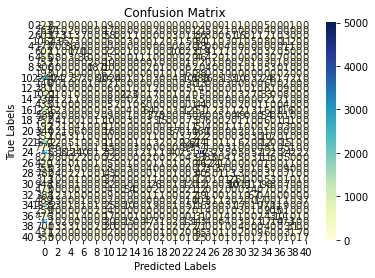

In [ ]:
# Render Confusion Matrix as Seaborn Heatmap Visualization
cmat_(cmat)

In [ ]:
# Create Classification Report with Summary Statistics/Metrics
print(classification_report(y_true=y_test.values.argmax(axis=1),
                            y_pred=y_pred.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.01      0.88      0.02       257
           1       0.41      0.10      0.17       356
           2       0.57      0.18      0.27       981
           3       0.74      0.07      0.13      1311
           4       0.41      0.15      0.22       234
           5       0.68      0.15      0.25      1114
           6       0.54      0.06      0.11       575
           7       0.67      0.01      0.02       185
           8       0.90      0.35      0.51       529
           9       0.60      0.02      0.04       258
          10       0.62      0.28      0.39      3646
          11       0.33      0.01      0.01       178
          12       0.00      0.00      0.00       320
          13       0.69      0.17      0.27      1324
          14       0.20      0.01      0.01       271
          15       0.60      0.01      0.02       506
          16       0.47      0.04      0.08      1520
          17       0.84    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
